<a href="https://colab.research.google.com/github/arturodeleon19/Data-Science-Projects-NLP-Tensorflow/blob/main/Emotion%20Text%20Classification/Emotion_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/emotion-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotion-dataset


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras # for compatibility with tensorflow hub
from tensorflow.keras import layers, regularizers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import TextVectorization
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv(path + "/Emotion_classify_Data.csv")
df.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


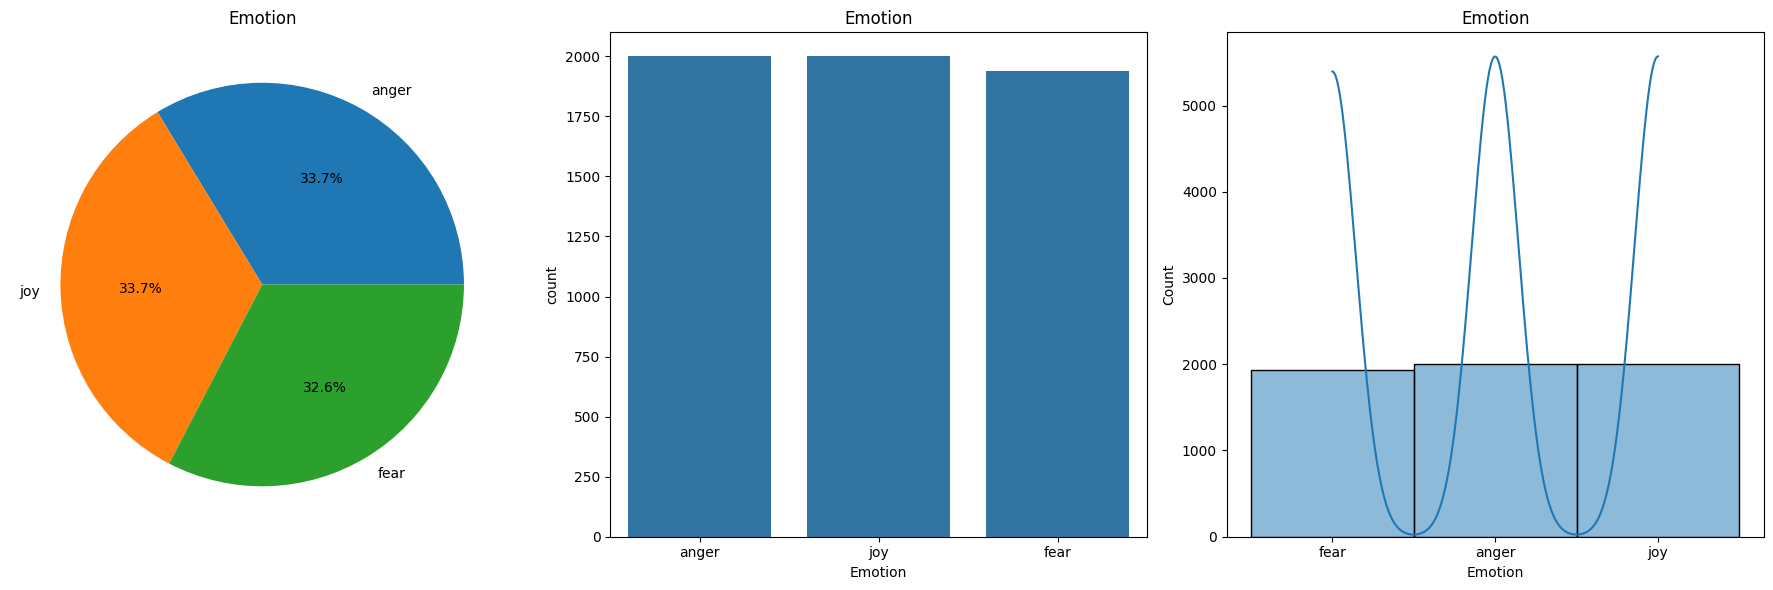

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

rank = df['Emotion'].value_counts()
axs[0].pie(rank, labels=rank.index, autopct='%1.1f%%')
axs[0].set_title('Emotion')

sns.barplot(df['Emotion'].value_counts(), ax=axs[1])
axs[1].set_title('Emotion')
axs[1].set_xlabel('Emotion')

sns.histplot(df['Emotion'], ax=axs[2], kde=True)
axs[2].set_title('Emotion')
axs[2].set_xlabel('Emotion')

plt.tight_layout()
plt.show()


In [ ]:
random_sample = df.sample(n=10)
for idx, row in random_sample.iterrows():
    print(f"Comment: {row['Comment']}")
    print(f"Emotion: {row['Emotion']}")
    print("-" * 50)

Comment: i feel grumpy to wake up so early
Emotion: anger
--------------------------------------------------
Comment: i feel agitated she said and we continued on to the corner of main and hastings where we saw three or four cops in the middle of a take down and my friend who has an anxiety disorder insisted we get on the wrong bus just to get away
Emotion: fear
--------------------------------------------------
Comment: ive seen the way serina feels strange if shes not being useful and it sure helps that the cleaner is pretty expensive and not having to pay that money would be pretty great
Emotion: fear
--------------------------------------------------
Comment: i felt like facebook was a catalyst for me to feel that way about myself and i started to see it as a bit of a hostile online community
Emotion: anger
--------------------------------------------------
Comment: i feel so honored and grateful to have met kassim selamat of the swallows during my trip
Emotion: joy
---------------

In [ ]:
X = df['Comment'].to_numpy()
y = df['Emotion'].to_numpy()

train_sentences, val_sentences, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)
len(train_sentences), len(val_sentences)

(4749, 1188)

In [ ]:
# Find the average number of words
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

19

In [ ]:
# Setup  and adapt text vectorization
max_vocab_length = 10000
max_length = 19

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

text_vectorizer.adapt(train_sentences)

In [ ]:
tf.random.set_seed(42)

model_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs, name="model_LSTM")

# Compile Model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()

Model: "model_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 19)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 19, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 19, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,366,787 (5.21 MB)

 Trainable params: 1,366,787 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time = time.time()

# Encode string labels to integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

history = model.fit(train_sentences,
                    train_labels_encoded,
                    epochs=100,
                    validation_data=(val_sentences, val_labels_encoded),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)])

end_time = time.time()
model_time = end_time - start_time
print(f"Total training time: {model_time} seconds")

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4193 - loss: 1.0442 - val_accuracy: 0.7795 - val_loss: 0.6044 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8763 - loss: 0.3442 - val_accuracy: 0.8401 - val_loss: 0.4715 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9540 - loss: 0.1531 - val_accuracy: 0.8131 - val_loss: 0.7270 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9672 - loss: 0.0989 - val_accuracy: 0.8552 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9837 - loss: 0.0550 - val_accuracy: 0.8460 - val_loss: 0.5695 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9900 - loss: 0.0328 - val_accuracy: 0.8485 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 7/100
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9920 - loss: 0

In [ ]:
tf.random.set_seed(42)

model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_2")

# Bidirectional RNN Model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_Bidirectional")

# Compile Model_2
model_2.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model_2.summary()

Model: "model_2_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 19)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 19, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 19, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,478,019 (5.64 MB)

 Trainable params: 1,478,019 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time = time.time()

history_2 = model_2.fit(train_sentences,
                    train_labels_encoded,
                    epochs=100,
                    validation_data=(val_sentences, val_labels_encoded),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)])

end_time = time.time()
model_2_time = end_time - start_time
print(f"Total training time: {model_2_time} seconds")

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4496 - loss: 1.0207 - val_accuracy: 0.8359 - val_loss: 0.4334 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9021 - loss: 0.2780 - val_accuracy: 0.8476 - val_loss: 0.4429 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9543 - loss: 0.1284 - val_accuracy: 0.8527 - val_loss: 0.4847 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9769 - loss: 0.0779 - val_accuracy: 0.8418 - val_loss: 0.6400 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9797 - loss: 0.0669 - val_accuracy: 0.8409 - val_loss: 0.6126 - learning_rate: 0.0010
Epoch 6/100
146/149 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9891 - loss: 0.0323
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9891 - lo

In [ ]:
tf.random.set_seed(42)

model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_3")

# 1-dimensional convolutional model

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_Conv1D")

# Compile Conv1D model
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


model_3.summary()

Model: "model_3_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 19)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 19, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 32)         │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,302,819 (4.97 MB)

 Trainable params: 1,302,819 (4.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time = time.time()

history_3 = model_3.fit(train_sentences,
                    train_labels_encoded,
                    epochs=100,
                    validation_data=(val_sentences, val_labels_encoded),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)])

end_time = time.time()
model_3_time = end_time - start_time
print(f"Total training time: {model_3_time} seconds")

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4063 - loss: 1.0791 - val_accuracy: 0.8089 - val_loss: 0.5677 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8783 - loss: 0.3518 - val_accuracy: 0.8687 - val_loss: 0.3049 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9745 - loss: 0.0855 - val_accuracy: 0.8653 - val_loss: 0.3492 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9955 - loss: 0.0205 - val_accuracy: 0.8678 - val_loss: 0.3821 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9993 - loss: 0.0070 - val_accuracy: 0.8704 - val_loss: 0.4063 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9993 - loss: 0.0047 - val_accuracy: 0.8721 - val_loss: 0.4307 - learning_rate: 0.0010
Epoch 7/100
142/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.

In [ ]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

# Create model
model_4 = tf_keras.Sequential([
  sentence_encoder_layer,
  tf_keras.layers.Dense(64, activation="relu"),
  tf_keras.layers.Dense(3, activation="softmax")
], name="model_4_USE")

# Compile model 4
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4.summary()

Model: "model_4_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 256830851 (979.73 MB)
Trainable params: 33027 (129.01 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
start_time = time.time()

history_4 = model_4.fit(train_sentences,
                    train_labels_encoded,
                    epochs=100,
                    validation_data=(val_sentences, val_labels_encoded),
                    callbacks=[tf_keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                               tf_keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)])

end_time = time.time()
model_4_time = end_time - start_time
print(f"Total training time: {model_4_time} seconds")

Epoch 1/100
208/208 [==============================] - 11s 34ms/step - loss: 1.8631 - accuracy: 0.4023 - val_loss: 1.7897 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 2/100
208/208 [==============================] - 6s 29ms/step - loss: 1.7894 - accuracy: 0.4039 - val_loss: 1.7808 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 3/100
208/208 [==============================] - 5s 26ms/step - loss: 1.7713 - accuracy: 0.4042 - val_loss: 1.7810 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 4/100
208/208 [==============================] - 6s 29ms/step - loss: 1.7569 - accuracy: 0.4050 - val_loss: 1.7785 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 5/100
208/208 [==============================] - 5s 26ms/step - loss: 1.7430 - accuracy: 0.4059 - val_loss: 1.7842 - val_accuracy: 0.4008 - lr: 0.0010
Epoch 6/100
208/208 [==============================] - 5s 25ms/step - loss: 1.7300 - accuracy: 0.4065 - val_loss: 1.7854 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 7/100
208/208 [==============================] - 5s

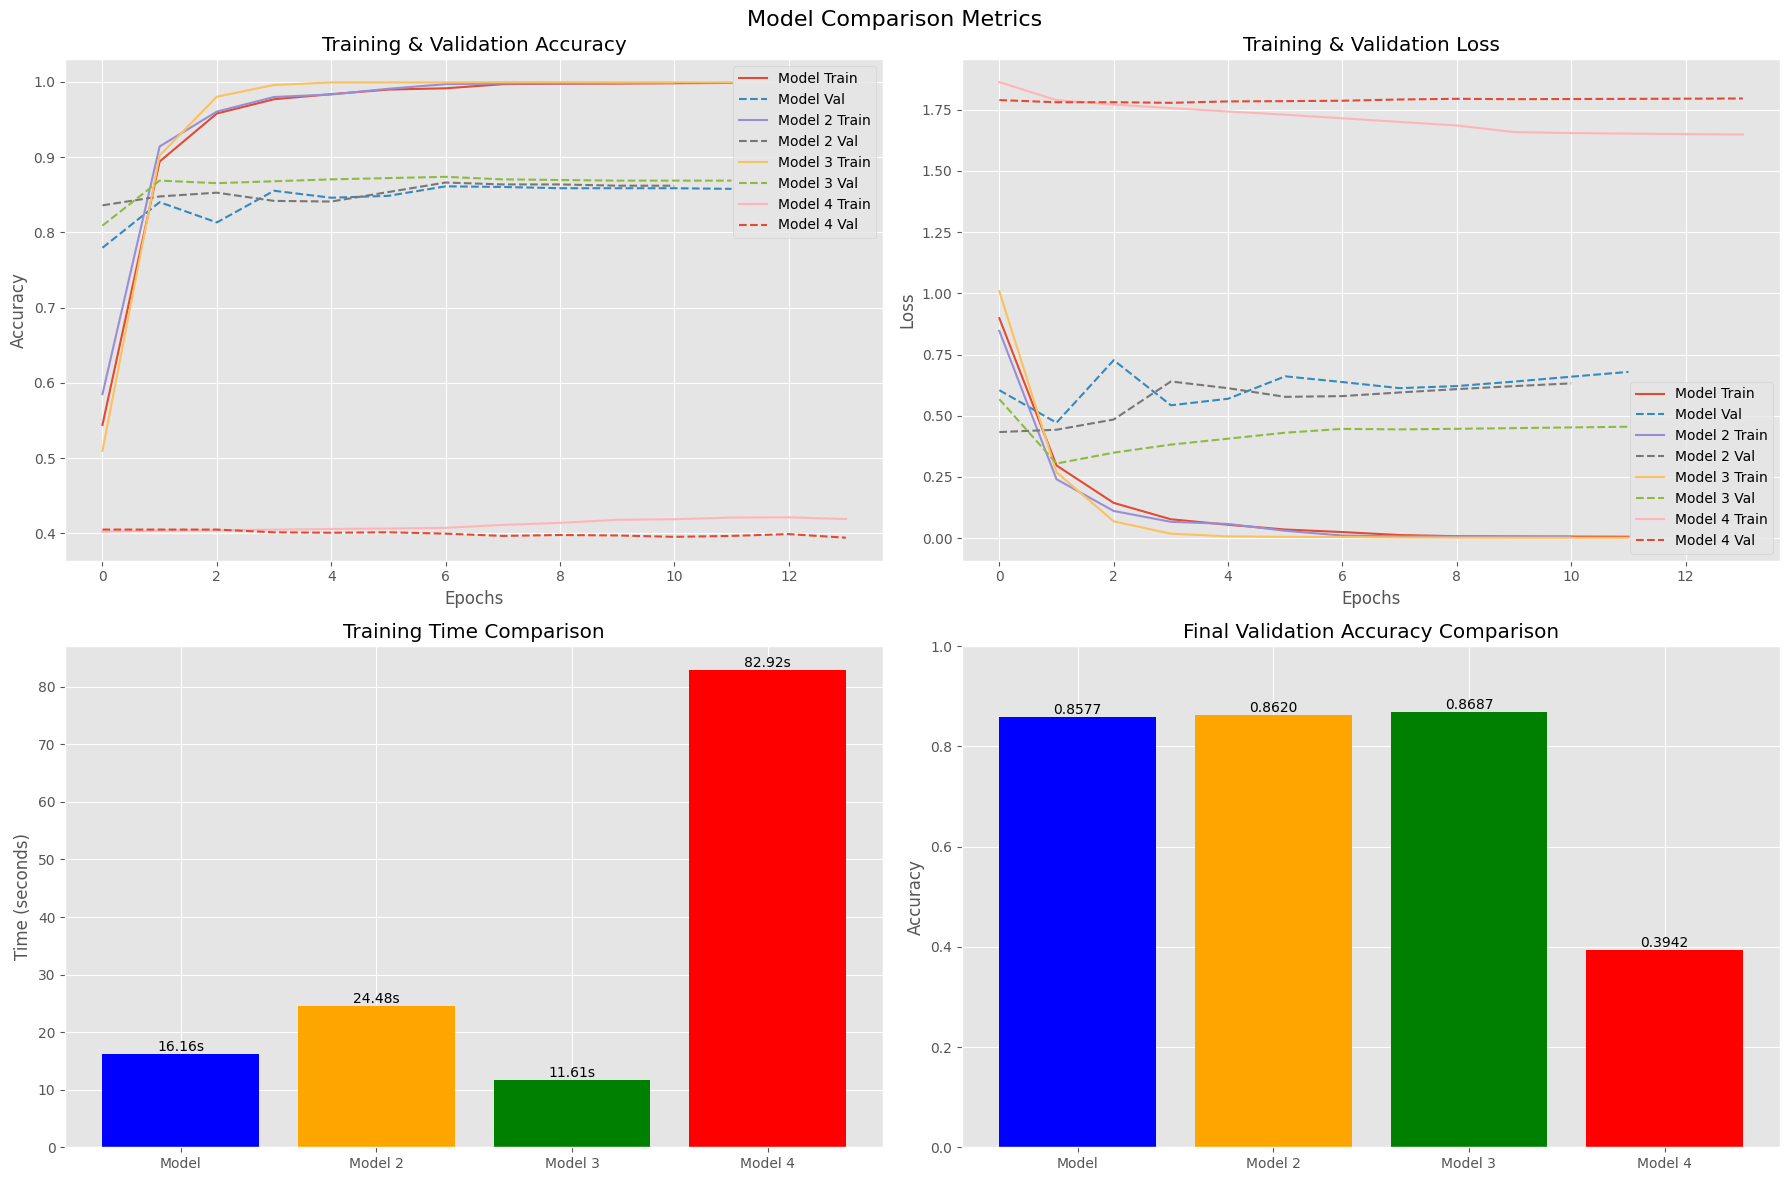

In [ ]:
# Set style
plt.style.use('ggplot')

# Model names for labeling
model_names = ['Model', 'Model 2', 'Model 3', 'Model 4']
histories = [history, history_2, history_3, history_4]
times = [model_time, model_2_time, model_3_time, model_4_time]

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Model Comparison Metrics', fontsize=16)

# 1. Training & Validation Accuracy Comparison
ax1 = axes[0, 0]
for i, hist in enumerate(histories):
    ax1.plot(hist.history['accuracy'], label=f'{model_names[i]} Train', linestyle='-')
    ax1.plot(hist.history['val_accuracy'], label=f'{model_names[i]} Val', linestyle='--')
ax1.set_title('Training & Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# 2. Training & Validation Loss Comparison
ax2 = axes[0, 1]
for i, hist in enumerate(histories):
    ax2.plot(hist.history['loss'], label=f'{model_names[i]} Train', linestyle='-')
    ax2.plot(hist.history['val_loss'], label=f'{model_names[i]} Val', linestyle='--')
ax2.set_title('Training & Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# 3. Training Time Comparison
ax3 = axes[1, 0]
bars = ax3.bar(model_names, times, color=['blue', 'orange', 'green', 'red'])
ax3.set_title('Training Time Comparison')
ax3.set_ylabel('Time (seconds)')
# Add time values on top of bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s',
             ha='center', va='bottom')

# 4. Final Validation Accuracy Comparison
ax4 = axes[1, 1]
val_accs = [hist.history['val_accuracy'][-1] for hist in histories]
bars = ax4.bar(model_names, val_accs, color=['blue', 'orange', 'green', 'red'])
ax4.set_title('Final Validation Accuracy Comparison')
ax4.set_ylabel('Accuracy')
ax4.set_ylim(0, 1)
# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
38/38 [==============================] - 1s 7ms/step


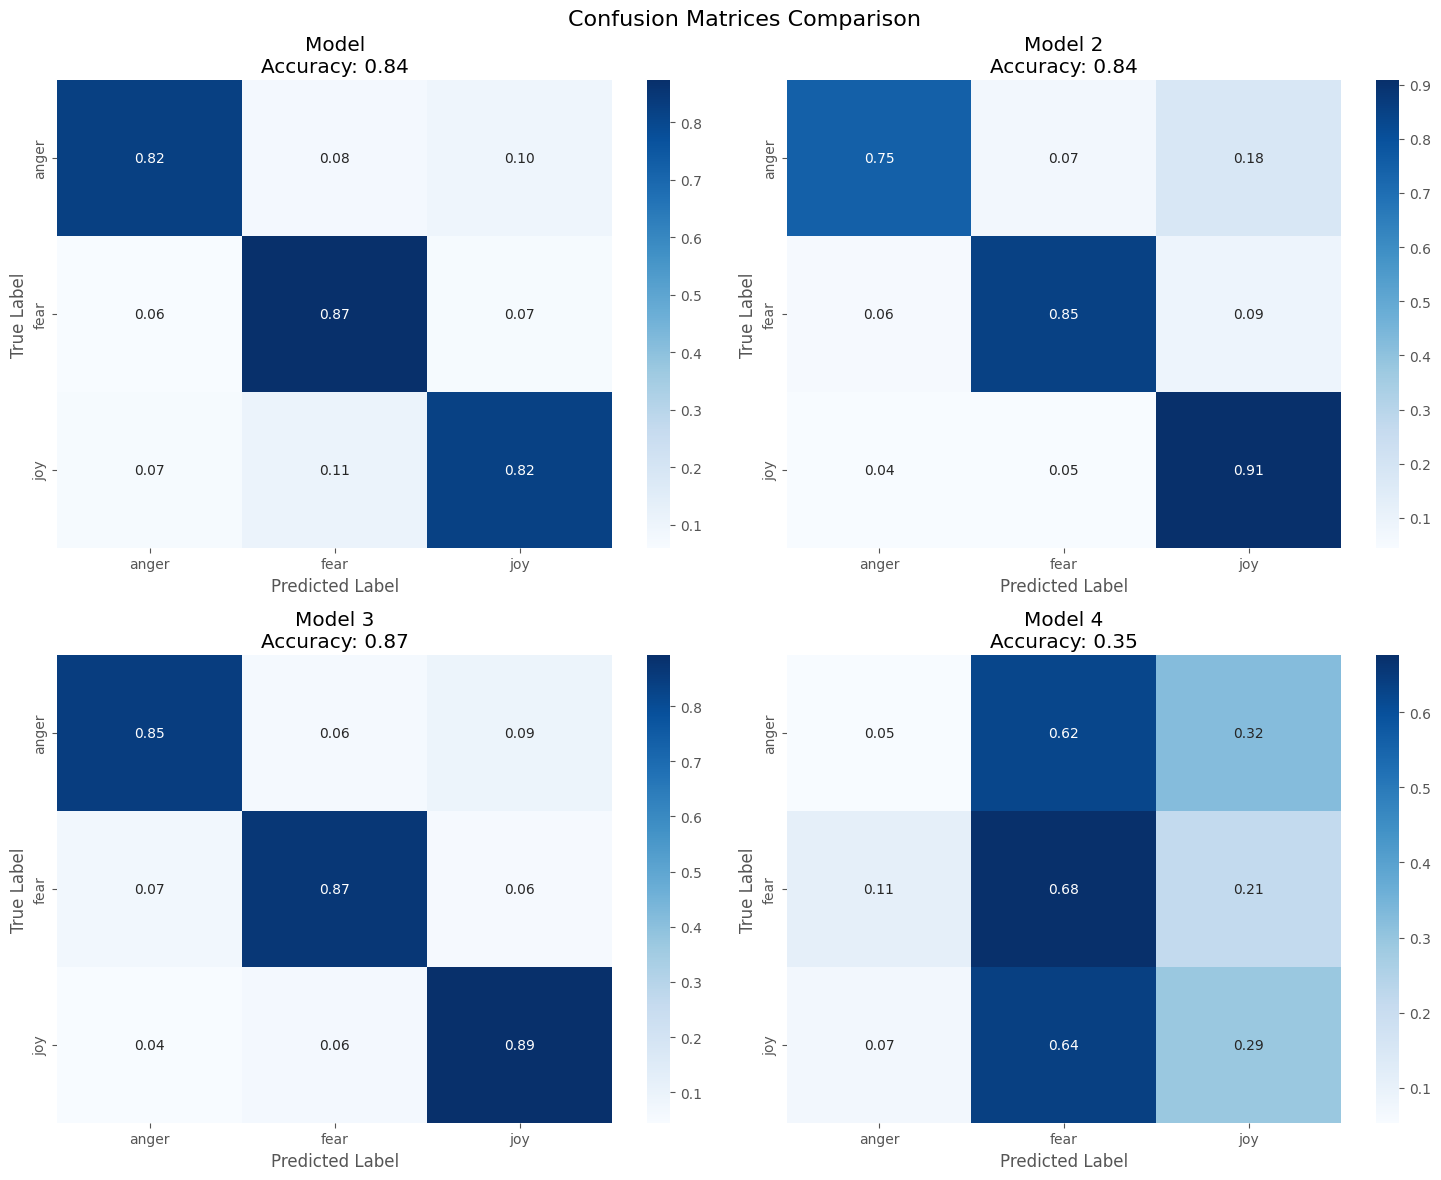

In [ ]:
# Get class names from label encoder
class_names = label_encoder.classes_

models = [model, model_2, model_3, model_4]
model_names = ['Model', 'Model 2', 'Model 3', 'Model 4']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Confusion Matrices Comparison', fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate predictions and plot confusion matrix for each model
for i, (current_model, name) in enumerate(zip(models, model_names)):
    # Get predictions
    y_pred = current_model.predict(val_sentences)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(val_labels_encoded, y_pred_classes)

    # Normalize the confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot using seaborn
    sns.heatmap(cm_norm,
                annot=True,
                fmt='.2f',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=axes[i])

    axes[i].set_title(f'{name}\nAccuracy: {np.mean(val_labels_encoded == y_pred_classes):.2f}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()